#### Tech Challenge - Fase 2 - Machine Learning and Time Series

#### O problema 

Desenvolver um modelo preditivo capaz de prever se o índice IBOVESPA vai fechar em alta ou baixa no dia seguinte, com base em dados históricos do próprio índice

#### O que é o índice Ibovespa 

É o principal indicador de desempenho das ações negociadas na B3 e reúne as empresas mais importantes do mercado de capitais brasileiro. Foi criado em 1968 e, ao longo desses 50 anos, consolidou-se como referência para investidores ao redor do mundo.


https://pt.wikipedia.org/wiki/Ibovespa

https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/ibovespa.htm

#### Fonte de dados 

Dados históricos do índice IBOVESPA disponíveis publicamente no link https://br.investing.com/indices/bovespa-historical-data e importando para o seguinte repositorio do Github https://github.com/RicardViana/fiap-Machine-Learning-and-Time-Series/blob/main/Dados%20Hist%C3%B3ricos%20Ibovespa.csv

#### Dicionário de dados


| Nome da Coluna | Descrição | Tipo de Dado |
| :--- | :--- | :--- |
| `Data` | A data da observação, no formato "DD/MM/AAAA". | Texto (object) |
| `Ultimo` | O preço de fechamento do Ibovespa no dia. | Numérico (float64) |
| `Abertura` | O preço de abertura do Ibovespa no dia. | Numérico (float64) |
| `Maxima` | O preço máximo atingido pelo Ibovespa no dia. | Numérico (float64) |
| `Minima` | O preço mínimo atingido pelo Ibovespa no dia. | Numérico (float64) |
| `Volume` | O volume de negociações do dia. Os valores são representados em texto com sufixos (ex: "B" para bilhões, "M" para milhões). | Texto (object) |
| `Variacao` | A variação percentual do Ibovespa no dia. | Texto (object) |

#### Objetivo

Criar um modelo que preveja se o fechamento do IBOVESPA do dia seguinte será maior ou menor que o do dia atual, ou seja:

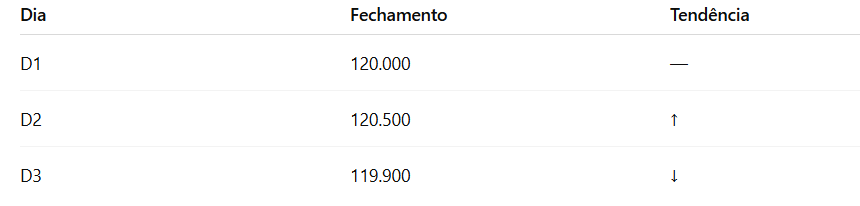

Onde deve prever a tendência (↑ ou ↓) com acuracidade mínima de 75% em um conjunto de teste, esse que contera o último mês (30 dias) de dados disponíveis

#### Desenvolvimento

##### Importação de bibliotecas e pacotes

In [ ]:
# Importar biblioteca completa
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import calendar
import numpy as np

# Importar função especifica de um módulo
from statsmodels.tsa.seasonal import seasonal_decompose # --> Gerar a decomposição dos dados
from sklearn.preprocessing import StandardScaler # --> Normalizar os dados
from datetime import date

# Importar função especifica de um módulo --> Modelos de ML
from sklearn.ensemble import RandomForestClassifier # --> Modelo de ML Random Forest
from sklearn.linear_model import LogisticRegression # --> Modelo de ML Regressão Logistica 
from catboost import CatBoostClassifier # --> Modelo de ML CatBoost
from lightgbm import LGBMClassifier # --> Modelo de ML LightGBM
from xgboost import XGBClassifier # --> Modelo de ML XGBoost
from sklearn.svm import SVC # --> Modelo de ML SVC

# Importar função especifica de um módulo --> Metricas para analisar o modelo  
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,accuracy_score

# Importar função especifica de um módulo --> Melhores hiperparametros 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline

# Outros import
import ipywidgets as widgets
from IPython.display import display

##### Criação de funções (DEF)

In [ ]:
# Função para gerar a matriz de confusão e a curva roc

def analisar_modelo_selecionado(nome_modelo, modelos_avaliados, y_test, x_test_scaled):
    
    # Salvar o modelo e a previsão em suas respectivas variaveis
    modelo_selecionado = modelos_avaliados[nome_modelo]["modelo"]
    previsoes_selecionadas = modelos_avaliados[nome_modelo]["previsoes"]

    print(f"Análise Detalhada para o Modelo: {nome_modelo}")
    
    # Gerar o gráfico de Matriz de Confusão
    cm = confusion_matrix(y_test, previsoes_selecionadas)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Previsto Negativo', 'Previsto Positivo'], 
                yticklabels=['Real Negativo', 'Real Positivo'])
    plt.title(f'Matriz de Confusão - {nome_modelo}', fontsize=14)
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Previsto')

    # Gerar o gráfico de Curva ROC e AUC
    # IF por com do modelo SVM pois ele não tem o predict_proba

    if hasattr(modelo_selecionado, "predict_proba"):
        y_pred_proba = modelo_selecionado.predict_proba(x_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

        plt.subplot(1, 2, 2) # Cria um subplot na posição 2
        plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc:.4f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Classificador Aleatório')
        plt.xlabel('Taxa de Falsos Positivos (FPR)')
        plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
        plt.title(f'Curva ROC - {nome_modelo}', fontsize=14)
        plt.legend()
        plt.grid()

    else:
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, 'Curva ROC não disponível\npara este modelo (ex: SVM sem probabilidade).', 
                 ha='center', va='center', fontsize=12)
        plt.title(f'Curva ROC - {nome_modelo}', fontsize=14)
        plt.gca().set_axis_off()

    plt.tight_layout()
    plt.show()

In [ ]:
# Função para criar os lags 

def criar_n_lags(df, n_lags, column):
    for i in range(1, n_lags + 1):
        df[f"{column}_lag{i}"] = df[column].shift(i)
    return df

##### Análise Exploratória de Dados (EDA)

In [ ]:
"""

Com sugestão do colega da pós Tiago Turra existe uma biblioteca chamada yfinance (https://pypi.org/project/yfinance/) que possi os mesmo dados do site https://br.investing.com/indices/bovespa-historical-data

"""

# Importando os dados via yfinance apenas para referencia
# progress --> Não gerar um print do progresso
# auto_adjust --> corrigir o histórico de preços
# multi_level_index --> Utilizando para evitar gerar coluna com o nome do ticket, exemplo ('Close', '^BVSP')

dados_origem = yf.download('^BVSP', period="max", interval="1d", auto_adjust=True,  progress=False, multi_level_index=False)

print("Primeiros dados")
display(dados_origem.head())

print("\nUltimos dados")
display(dados_origem.tail())

In [ ]:
# Verificando o intervalo de data dos dados 

print(f"Data inicial é {dados_origem.index.min()}")
print(f"Data final   é {dados_origem.index.max()}")

In [ ]:
# Veficiando os dados dados do data frame 

dados_origem.info()

In [ ]:
# Verificando o index

dados_origem.index

In [ ]:
# Verificando os dados nulos

dados_origem.isnull().sum()

In [ ]:
# Gerando a estatistica descritiva do data frame 

dados_origem.describe()

In [ ]:
# Criando um novo data frame apenas com os campos necessarios

dados_ultimo = dados_origem["Close"].copy()
dados_ultimo.tail()

In [ ]:
# Plotando um grafico de linha 

plt.figure(figsize=(15,5))
plt.plot(dados_ultimo.index,dados_ultimo)
plt.title("Evolução do indice Ibovespa (IBOV)")
plt.show()

In [ ]:
# Realizar a decomposição da seria temporal -->  tendência (trend), sazonalidade (seasonal) e resíduo (resid) e gerar o graficos 

periodo = 252 # Média de dias uteis

resultados = seasonal_decompose(dados_ultimo, period=periodo)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultados.observed.plot(ax=ax1)
ax1.set_title("Serie Real")

resultados.trend.plot(ax=ax2)
ax2.set_title("Tendência")

resultados.seasonal.plot(ax=ax3)
ax3.set_title("Sazonalidade")

resultados.resid.plot(ax=ax4)
ax4.set_title("Resíduo")

plt.tight_layout()
plt.show()

In [ ]:
# Filtrar dados com volume maior que zero

dados_origem_volume_zero = dados_origem.query("Volume > 0")

print("Dados antes do filtro")
display(dados_origem.head())

print("\nDados após o filtro")
dados_origem_volume_zero.head()

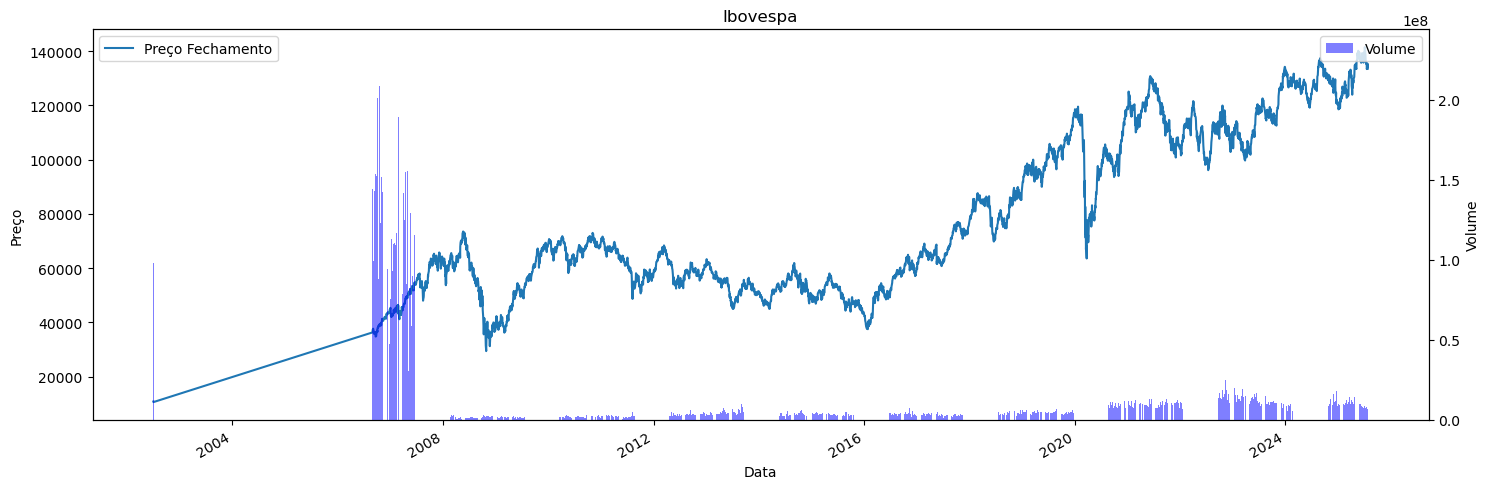

In [277]:
# Plotar o grafico Preco vs Volume 

ax = dados_origem_volume_zero.plot(y='Close', kind='line', label='Preço Fechamento')
ax.set_title('Ibovespa')
ax.set_xlabel('Data')
ax.set_ylabel('Preço')
fig = ax.get_figure()
fig.set_figwidth(15)
fig.set_figheight(5)

ax2 = ax.twinx()
ax2.bar(dados_origem_volume_zero.index, dados_origem_volume_zero['Volume'], alpha=0.5, color='blue', label='Volume')
ax2.set_ylabel('Volume')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()

##### Feature Engineering e Target

In [278]:
# Criar um novo data frame com os dados originais

dados = dados_origem.copy()

In [279]:
# Ordernando os dados 

dados = dados.sort_index()

In [280]:
# Criar uma coluna Delta do valor Close (Fechamento)

dados["Delta"] = dados["Close"].diff().shift(1)
dados.tail()

,Close,High,Low,Open,Volume,Delta
Date,,,,,,
2025-07-21,134167.0,134865.0,133367.0,133382.0,6726700,-2183.0
2025-07-22,134036.0,135300.0,133986.0,134180.0,7052100,785.0
2025-07-23,135368.0,135782.0,133676.0,134036.0,6527600,-131.0
2025-07-24,133808.0,135363.0,133648.0,135357.0,5976800,1332.0
2025-07-25,133524.0,134204.0,133285.0,133820.0,5560900,-1560.0


In [281]:
# Criar uma coluna binaria com o Target --> Subiu ou desceu o indice 

# Desconsiderar variação menor 0.5% --> Ruidoss
limite = 0.005  

# Criar coluna target com validação do limite
delta = dados['Close'].diff()
dados['Target'] = np.where(delta > limite, 1, np.where(delta < -limite, 0, np.nan))

dados.tail()

,Close,High,Low,Open,Volume,Delta,Target
Date,,,,,,,
2025-07-21,134167.0,134865.0,133367.0,133382.0,6726700,-2183.0,1.0
2025-07-22,134036.0,135300.0,133986.0,134180.0,7052100,785.0,0.0
2025-07-23,135368.0,135782.0,133676.0,134036.0,6527600,-131.0,1.0
2025-07-24,133808.0,135363.0,133648.0,135357.0,5976800,1332.0,0.0
2025-07-25,133524.0,134204.0,133285.0,133820.0,5560900,-1560.0,0.0


In [282]:
# Criar uma coluna com variação percentual do valor do fechamento

dados["Return"] = dados["Close"].pct_change().shift(1)
dados.tail()

,Close,High,Low,Open,Volume,Delta,Target,Return
Date,,,,,,,,
2025-07-21,134167.0,134865.0,133367.0,133382.0,6726700,-2183.0,1.0,-0.016103
2025-07-22,134036.0,135300.0,133986.0,134180.0,7052100,785.0,0.0,0.005885
2025-07-23,135368.0,135782.0,133676.0,134036.0,6527600,-131.0,1.0,-0.000976
2025-07-24,133808.0,135363.0,133648.0,135357.0,5976800,1332.0,0.0,0.009938
2025-07-25,133524.0,134204.0,133285.0,133820.0,5560900,-1560.0,0.0,-0.011524


In [283]:
# Criar os lags --> Features Defasadas ou Lagged Features

n_lags = 10

dataset = criar_n_lags(dados, n_lags, "Target")
dados.tail()

,Close,High,Low,Open,Volume,Delta,Target,Return,Target_lag1,Target_lag2,Target_lag3,Target_lag4,Target_lag5,Target_lag6,Target_lag7,Target_lag8,Target_lag9,Target_lag10
Date,,,,,,,,,,,,,,,,,,
2025-07-21,134167.0,134865.0,133367.0,133382.0,6726700,-2183.0,1.0,-0.016103,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-07-22,134036.0,135300.0,133986.0,134180.0,7052100,785.0,0.0,0.005885,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-07-23,135368.0,135782.0,133676.0,134036.0,6527600,-131.0,1.0,-0.000976,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2025-07-24,133808.0,135363.0,133648.0,135357.0,5976800,1332.0,0.0,0.009938,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2025-07-25,133524.0,134204.0,133285.0,133820.0,5560900,-1560.0,0.0,-0.011524,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [284]:
# Empurrar(shift) os dados High e Low + Criar coluna Volatilidade

dados["HighShift"] = dados["High"].shift(1)
dados["LowShift"] = dados["Low"].shift(1)

dados["Volatilidade"] = dados["HighShift"] - dados["LowShift"]
dados["Volatilidade_relativa"] = dados["Volatilidade"] / dados["LowShift"]

dados.tail()


,Close,High,Low,Open,Volume,Delta,Target,Return,Target_lag1,Target_lag2,...,Target_lag5,Target_lag6,Target_lag7,Target_lag8,Target_lag9,Target_lag10,HighShift,LowShift,Volatilidade,Volatilidade_relativa
Date,,,,,,,,,,,,,,,,,,,,,
2025-07-21,134167.0,134865.0,133367.0,133382.0,6726700,-2183.0,1.0,-0.016103,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,135563.0,133296.0,2267.0,0.017007
2025-07-22,134036.0,135300.0,133986.0,134180.0,7052100,785.0,0.0,0.005885,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,134865.0,133367.0,1498.0,0.011232
2025-07-23,135368.0,135782.0,133676.0,134036.0,6527600,-131.0,1.0,-0.000976,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,135300.0,133986.0,1314.0,0.009807
2025-07-24,133808.0,135363.0,133648.0,135357.0,5976800,1332.0,0.0,0.009938,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,135782.0,133676.0,2106.0,0.015755
2025-07-25,133524.0,134204.0,133285.0,133820.0,5560900,-1560.0,0.0,-0.011524,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,135363.0,133648.0,1715.0,0.012832


In [285]:
# dias_medias = [5, 22, 66, 132, 252] 

# for dias in dias_medias:
    # dados[f"MA_{dias}"] = dados["Close"].rolling(window=dias).mean().shift(1)

# dados.tail()

In [286]:
# Ajustar o Data Frame removendo colunas não necessarias e linhas com valores nulos 

colunas_excluir = ["Close", "High", "Low", "Volume"]
dados = dados.drop(columns=colunas_excluir)
dados = dados.dropna()

dados.index.name = "data"
dados = dados.rename(columns={"HighShift":"High", "LowShift":"Low"})

dados.tail()

,Open,Delta,Target,Return,Target_lag1,Target_lag2,Target_lag3,Target_lag4,Target_lag5,Target_lag6,Target_lag7,Target_lag8,Target_lag9,Target_lag10,High,Low,Volatilidade,Volatilidade_relativa
data,,,,,,,,,,,,,,,,,,
2025-07-21,133382.0,-2183.0,1.0,-0.016103,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135563.0,133296.0,2267.0,0.017007
2025-07-22,134180.0,785.0,0.0,0.005885,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,134865.0,133367.0,1498.0,0.011232
2025-07-23,134036.0,-131.0,1.0,-0.000976,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,135300.0,133986.0,1314.0,0.009807
2025-07-24,135357.0,1332.0,0.0,0.009938,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,135782.0,133676.0,2106.0,0.015755
2025-07-25,133820.0,-1560.0,0.0,-0.011524,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,135363.0,133648.0,1715.0,0.012832


##### Separa a base entre treino e test

In [287]:
# Gerar datas para filtrar treino e teste 

# Definir o ano e mês do intervalo + anos 
ano = 2025
mes = 6
anos = 10

# Gerar as variaveis 
data_inicio_teste = pd.to_datetime(date(ano, mes, 1))
ultimo_dia = calendar.monthrange(ano, mes)[1]
data_fim_teste = pd.to_datetime(date(ano, mes, ultimo_dia))

ano_atual = date.today().year
ano_inicio_treino = ano_atual - anos
data_inicio_treino = pd.to_datetime(date(ano_inicio_treino,1,1))

In [288]:
# Separar os dados para treino e teste 

preditores = list(dados.columns)
preditores.remove("Target")

x = dados[preditores]
y = dados["Target"]

print("Features (x):")
display(x.tail())

print("\nAlvo (y):")
display(y.tail())

Features (x):


,Open,Delta,Return,Target_lag1,Target_lag2,Target_lag3,Target_lag4,Target_lag5,Target_lag6,Target_lag7,Target_lag8,Target_lag9,Target_lag10,High,Low,Volatilidade,Volatilidade_relativa
data,,,,,,,,,,,,,,,,,
2025-07-21,133382.0,-2183.0,-0.016103,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135563.0,133296.0,2267.0,0.017007
2025-07-22,134180.0,785.0,0.005885,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,134865.0,133367.0,1498.0,0.011232
2025-07-23,134036.0,-131.0,-0.000976,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,135300.0,133986.0,1314.0,0.009807
2025-07-24,135357.0,1332.0,0.009938,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,135782.0,133676.0,2106.0,0.015755
2025-07-25,133820.0,-1560.0,-0.011524,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,135363.0,133648.0,1715.0,0.012832



Alvo (y):


data
2025-07-21    1.0
2025-07-22    0.0
2025-07-23    1.0
2025-07-24    0.0
2025-07-25    0.0
Name: Target, dtype: float64

In [289]:
# Separar a base em treino e teste

x_train = x[(x.index >= data_inicio_treino) & (x.index < data_inicio_teste)]
y_train = y[(y.index >= data_inicio_treino) & (y.index < data_inicio_teste)]

x_test = x[(x.index >= data_inicio_teste) & (x.index <= data_fim_teste)]
y_test = y[(y.index >= data_inicio_teste) & (y.index <= data_fim_teste)]

##### Criação dos modelos de Machine Learning

In [290]:
tscv = TimeSeriesSplit(n_splits=5)

In [291]:
pipe_lr = Pipeline(
    [('scaler', StandardScaler()), ('clf', LogisticRegression(solver='liblinear'))]
)

param_grid_lr = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],  # regularização
    'clf__penalty': ['l1', 'l2'],  # tipo de penalização
    'clf__solver': ['liblinear'],  # necessário para suportar l1
}

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=tscv)
grid_lr.fit(x_train, y_train)

,estimator,Pipeline(step...liblinear'))])
,param_grid,"{'clf__C': [0.001, 0.01, ...], 'clf__penalty': ['l1', 'l2'], 'clf__solver': ['liblinear']}"
,scoring,None
,n_jobs,None
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [292]:
pipe_xgb = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('clf', XGBClassifier()),
    ]
)

param_grid_xgb = {
    'clf__n_estimators': [50, 100, 200],  # número de árvores
    'clf__max_depth': [3, 5, 7],  # profundidade da árvore
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.3],  # taxa de aprendizado
    'clf__subsample': [0.6, 0.8, 1.0],  # fração das amostras usadas em cada árvore
    'clf__colsample_bytree': [0.6, 0.8, 1.0],  # fração de colunas usadas por árvore
    'clf__gamma': [0, 0.1, 0.5, 1.0],  # regularização mínima para divisão
    'clf__reg_alpha': [0, 0.1, 1],  # L1 regularization
    'clf__reg_lambda': [0.1, 1, 10],  # L2 regularization
}

grid_xgb = RandomizedSearchCV(pipe_xgb, param_grid_xgb, cv=tscv)
grid_xgb.fit(x_train, y_train)

,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'clf__colsample_bytree': [0.6, 0.8, ...], 'clf__gamma': [0, 0.1, ...], 'clf__learning_rate': [0.01, 0.05, ...], 'clf__max_depth': [3, 5, ...], ...}"
,n_iter,10
,scoring,None
,n_jobs,None
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [293]:
print("Logistic Regression:")
print("Melhores parâmetros:", grid_lr.best_params_)
print("Acurácia:", accuracy_score(y_test, grid_lr.predict(x_test)))
print(classification_report(y_test, grid_lr.predict(x_test)))

Logistic Regression:
Melhores parâmetros: {'clf__C': 0.001, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Acurácia: 0.65
              precision    recall  f1-score   support

         0.0       0.69      0.75      0.72        12
         1.0       0.57      0.50      0.53         8

    accuracy                           0.65        20
   macro avg       0.63      0.62      0.63        20
weighted avg       0.64      0.65      0.65        20



In [294]:
print("\nXGBoost:")
print("Melhores parâmetros:", grid_xgb.best_params_)
print("Acurácia:", accuracy_score(y_test, grid_xgb.predict(x_test)))
print(classification_report(y_test, grid_xgb.predict(x_test)))


XGBoost:
Melhores parâmetros: {'clf__subsample': 0.8, 'clf__reg_lambda': 0.1, 'clf__reg_alpha': 0, 'clf__n_estimators': 50, 'clf__max_depth': 5, 'clf__learning_rate': 0.01, 'clf__gamma': 1.0, 'clf__colsample_bytree': 0.8}
Acurácia: 0.45
              precision    recall  f1-score   support

         0.0       0.60      0.25      0.35        12
         1.0       0.40      0.75      0.52         8

    accuracy                           0.45        20
   macro avg       0.50      0.50      0.44        20
weighted avg       0.52      0.45      0.42        20



In [295]:
baseline_pred = y_test.shift(1).diff().dropna().apply(np.sign) + 1

# calculando a acurácia do baseline
baseline_accuracy = accuracy_score(y_test.loc[baseline_pred.index], baseline_pred)
print(f"Acurácia do baseline: {baseline_accuracy:.2f}")

Acurácia do baseline: 0.28


In [296]:
# acurácia dos modelos

# regressão logística
log_reg_accuracy = accuracy_score(y_test, grid_lr.predict(x_test))

# xgboost
xgb_accuracy = accuracy_score(y_test, grid_xgb.predict(x_test))

# criando a tabela de comparação
tabela_comparativa = pd.DataFrame(columns=['Modelo', 'Acurácia'])

tabela_comparativa.loc[0] = ['Baseline', f"{baseline_accuracy*100:.2f}%"]
tabela_comparativa.loc[1] = ['Logistic Regression', f"{log_reg_accuracy*100:.2f}%"]
tabela_comparativa.loc[2] = ['XGBoost', f"{xgb_accuracy*100:.2f}%"]

tabela_comparativa

,Modelo,Acurácia
0,Baseline,27.78%
1,Logistic Regression,65.00%
2,XGBoost,45.00%
